# Projet 4 : Anticipez les besoins électriques de bâtiments - Modélisation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
pd.set_option('display.max_row', 200)
pd.set_option('display.max_column', 200)
from IPython.display import display
# %matplotlib qt

## Lecture des fichiers

In [23]:
data_merge_5 = pd.read_csv('Cleaned_data.csv')

In [24]:
data_merge_5

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,PropertyGFATotal,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),GHGEmissionsTotal,LargestPropertyUseTypeGFARatio,LargestPropertyUseTypeCat5,Hospital (General Medical & Surgical)GFA,Data CenterGFA,Convention CenterGFA,CourthouseGFA,Urgent Care/Clinic/Other OutpatientGFA,OtherGFA,Hospital (General Medical & Surgical)GFARatio,Data CenterGFARatio,Convention CenterGFARatio,CourthouseGFARatio,Urgent Care/Clinic/Other OutpatientGFARatio,OtherGFARatio,OfficeGFA,Non-Refrigerated WarehouseGFA,K-12 SchoolGFA,Retail StoreGFA,HotelGFA,Worship FacilityGFA,Distribution CenterGFA,Medical OfficeGFA,Supermarket/Grocery StoreGFA,Other - RecreationGFA,Self-Storage FacilityGFA,ParkingGFA,Other - Entertainment/Public AssemblyGFA,College/UniversityGFA,Refrigerated WarehouseGFA,RestaurantGFA,Social/Meeting HallGFA,LaboratoryGFA,Multifamily HousingGFA,Manufacturing/Industrial PlantGFA,Automobile DealershipGFA,Other - Lodging/ResidentialGFA,MuseumGFA,LibraryGFA,Strip MallGFA,"Repair Services (Vehicle, Shoe, Locksmith, etc)GFA",Other - EducationGFA,Bank BranchGFA,Other - ServicesGFA,Financial OfficeGFA,Performing ArtsGFA,Other - MallGFA,Other/Specialty HospitalGFA,Fitness Center/Health Club/GymGFA,Prison/IncarcerationGFA,Adult EducationGFA,Other - Restaurant/BarGFA,Outpatient Rehabilitation/Physical TherapyGFA,Other - UtilityGFA,Food ServiceGFA,Pre-school/DaycareGFA,Lifestyle CenterGFA,Residence Hall/DormitoryGFA,Residential Care FacilityGFA,Other - Public ServicesGFA,"Personal Services (Health/Beauty, Dry Cleaning, etc)GFA",Wholesale Club/SupercenterGFA,Movie TheaterGFA,Police StationGFA,OfficeGFARatio,Non-Refrigerated WarehouseGFARatio,K-12 SchoolGFARatio,Retail StoreGFARatio,HotelGFARatio,Worship FacilityGFARatio,Distribution CenterGFARatio,Medical OfficeGFARatio,Supermarket/Grocery StoreGFARatio,Other - RecreationGFARatio,Self-Storage FacilityGFARatio,ParkingGFARatio,Other - Entertainment/Public AssemblyGFARatio,College/UniversityGFARatio,Refrigerated WarehouseGFARatio,RestaurantGFARatio,Social/Meeting HallGFARatio,LaboratoryGFARatio,Multifamily HousingGFARatio,Manufacturing/Industrial PlantGFARatio,Automobile DealershipGFARatio,Other - Lodging/ResidentialGFARatio,MuseumGFARatio,LibraryGFARatio,Strip MallGFARatio,"Repair Services (Vehicle, Shoe, Locksmith, etc)GFARatio",Other - EducationGFARatio,Bank BranchGFARatio,Other - ServicesGFARatio,Financial OfficeGFARatio,Performing ArtsGFARatio,Other - MallGFARatio,Other/Specialty HospitalGFARatio,Fitness Center/Health Club/GymGFARatio,Prison/IncarcerationGFARatio,Adult EducationGFARatio,Other - Restaurant/BarGFARatio,Outpatient Rehabilitation/Physical TherapyGFARatio,Other - UtilityGFARatio,Food ServiceGFARatio,Pre-school/DaycareGFARatio,Lifestyle CenterGFARatio,Residence Hall/DormitoryGFARatio,Residential Care FacilityGFARatio,Other - Public ServicesGFARatio,"Personal Services (Health/Beauty, Dry Cleaning, etc)GFARatio",Wholesale Club/SupercenterGFARatio,Movie TheaterGFARatio,Police StationGFARatio
0,NonResidential,Hotel,DOWNTOWN,1927,7,1,12,0.0,88434.0,Hotel,88434.0,88434.0,None,0.0,None,0.0,65.000000,6.981428e+06,7.097539e+06,249.43,1.000000,Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,NonResidential,Hotel,DOWNTOWN,1996,7,1,11,15064.0,88502.0,Hotel,83880.0,103566

## Preprocessing

In [25]:
# Définition des listes de variables
list_type = data_merge_5['LargestPropertyUseType'].value_counts().index.to_list()

list_gfa = [tp + 'GFA' for tp in list_type]
list_gfa_rat = [tp + 'Ratio' for tp in list_gfa]

lpt_t1_top = data_merge_5[['SiteEnergyUse(kBtu)', 'GHGEmissionsTotal', 'LargestPropertyUseType']].groupby(['LargestPropertyUseType']).mean().sort_values(by ='SiteEnergyUse(kBtu)', ascending = False)
list_cat5 = lpt_t1_top.index.to_list()[:5]
list_top5 = list_cat5 + ['Other']
list_top5_gfa = [tp + 'GFA' for tp in list_top5]


In [26]:
# Définition des variables catégorielles et quantitatives

categorical_features_a = ['PrimaryPropertyType', 'LargestPropertyUseType', 'BuildingType']
categorical_features_b = ['PrimaryPropertyType']

# Sans ENERGYSTARScore
numerical_features_1_1 =  ['PropertyGFABuilding(s)', 
                           'PropertyGFATotal',
                           'LargestPropertyUseTypeGFA', 
                           'NumberofFloors'
                          ]
numerical_features_2_1 =  ['PropertyGFABuilding(s)', 
                           'PropertyGFATotal',
                           'LargestPropertyUseTypeGFA',
                           'LargestPropertyUseTypeGFARatio',
                           #'NumberofFloors'
                          ]
numerical_features_3_1 =  ['PropertyGFABuilding(s)', 
                           'PropertyGFATotal', 
                           #'NumberofFloors'
                          ] + list_gfa_rat + list_gfa
# Avec ENERGYSTARScore
numerical_features_1_2 = numerical_features_1_1 + ['ENERGYSTARScore']
numerical_features_2_2 = numerical_features_2_1 + ['ENERGYSTARScore']
numerical_features_3_2 = numerical_features_3_1 + ['ENERGYSTARScore']

In [27]:
# Création des pipelines pour les différentes catégories
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer

numerical_pipeline = make_pipeline(FunctionTransformer(np.log1p),
                                   #QuantileTransformer(output_distribution = 'normal', n_quantiles = 100),
                                   RobustScaler()
                                  )
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

In [28]:
# Création du transformer preprocessor
from sklearn.compose import make_column_transformer

preprocessor_1_1 = make_column_transformer((numerical_pipeline, numerical_features_1_1),
                                           (categorical_pipeline, categorical_features_a))
preprocessor_1_2 = make_column_transformer((numerical_pipeline, numerical_features_1_2),
                                           (categorical_pipeline, categorical_features_a))
preprocessor_2_1 = make_column_transformer((numerical_pipeline, numerical_features_2_1),
                                           (categorical_pipeline, categorical_features_a))
preprocessor_2_2 = make_column_transformer((numerical_pipeline, numerical_features_2_2),
                                           (categorical_pipeline, categorical_features_a))
preprocessor_3_1 = make_column_transformer((numerical_pipeline, numerical_features_3_1),
                                           (categorical_pipeline, categorical_features_b))
preprocessor_3_2 = make_column_transformer((numerical_pipeline, numerical_features_3_2),
                                           (categorical_pipeline, categorical_features_b))

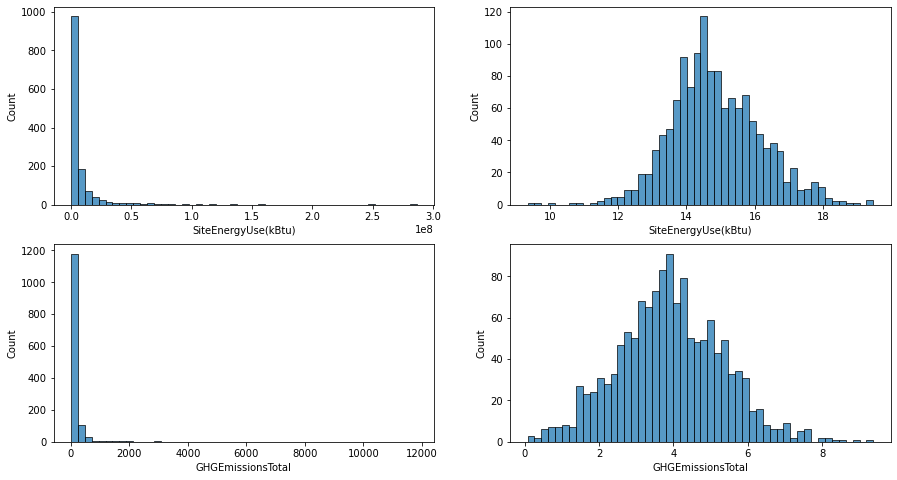

In [29]:
# Transformation et visualisation des targets
target_1 = np.log1p(data_merge_5['SiteEnergyUse(kBtu)'])
target_2 = np.log1p(data_merge_5['GHGEmissionsTotal'])

plt.figure(figsize = (15,8))
plt.subplot(2,2,1)
sns.histplot(data_merge_5['SiteEnergyUse(kBtu)'], bins = 50)
plt.subplot(2,2,2)
sns.histplot(target_1, bins = 50)
plt.subplot(2,2,3)
sns.histplot(data_merge_5['GHGEmissionsTotal'], bins = 50)
plt.subplot(2,2,4)
sns.histplot(target_2, bins = 50)
plt.savefig('Target_distributions.png', bbox_inches = 'tight')
plt.show()

In [30]:
# Définition des différents features possibles
features_1_1 = data_merge_5[categorical_features_a + numerical_features_1_1]
features_1_2 = data_merge_5[categorical_features_a + numerical_features_1_2]
features_2_1 = data_merge_5[categorical_features_a + numerical_features_2_1]
features_2_2 = data_merge_5[categorical_features_a + numerical_features_2_2]
features_3_1 = data_merge_5[categorical_features_b + numerical_features_3_1]
features_3_2 = data_merge_5[categorical_features_b + numerical_features_3_2]

# Modélisation

## Selection des targets, features et preprocessor

In [44]:
target = target_1
features = features_2_1
preprocessor = preprocessor_2_1

## Division train, test - Nombre de cross validation - Scoring

In [45]:
# Division entre training et test set
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2,
                                                                            random_state = 1)

# Nombre de cross validation
cv = 5

# Methode de scoring
scoring = 'neg_mean_squared_error'

## Définition de la baseline

In [46]:
# Création d'une baseline pour comparaison du modèle correspondant
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

baseline_model = make_pipeline(preprocessor, DummyRegressor(strategy = 'mean'))

# Cross validation de la baseline
from sklearn.model_selection import cross_val_score

val_score_0 = cross_val_score(baseline_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_0.mean()

-1.6951156003501981

## Régression linéaire et régularisation

### Regression linéaire 

In [47]:
# Création du modèle de regression lineaire
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

lreg_model = make_pipeline(preprocessor, LinearRegression())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_lr = cross_val_score(lreg_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_lr.mean()

-0.4916493564379952

In [48]:
# Recherche des meilleurs hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV
params = {}

grid_lr = GridSearchCV(lreg_model, param_grid = {},
                       return_train_score = True,
                       scoring = scoring, cv =cv)
grid_lr.fit(features_train, target_train)
best_score_lr = grid_lr.best_score_
best_param_lr = grid_lr.best_params_
best_estimator_lr = grid_lr.best_estimator_
grid_results_lr = pd.DataFrame(grid_lr.cv_results_)
display(best_score_lr, best_param_lr, grid_results_lr)

-0.4916493564379952

{}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.042037,0.01134,0.011251,0.003697,{},-0.516458,-0.606018,-0.365237,-0.564984,-0.405549,-0.491649,0.09216,1,-0.391573,-0.371878,-0.432636,-0.391656,-0.423182,-0.402185,0.022406


In [49]:
# Visualisation des coefficients du meilleur estimateur
best_lr_model = best_estimator_lr.named_steps['linearregression']

In [50]:
# Entrâinement et calcul des résidus du meilleur estimateur
best_estimator_lr.fit(features_train, target_train)
lr_target_trans_predict = best_estimator_lr.predict(features_train)
lr_residuals = target_train - lr_target_trans_predict

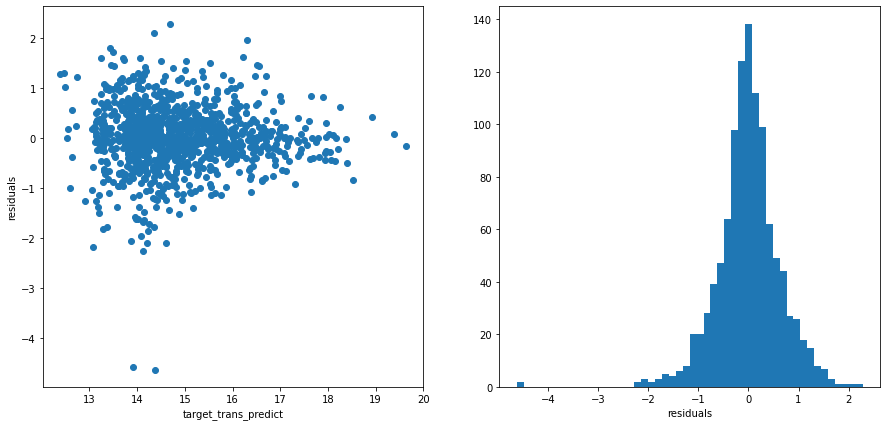

In [51]:
# Tracé des résidus 
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(lr_target_trans_predict, lr_residuals)
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(lr_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

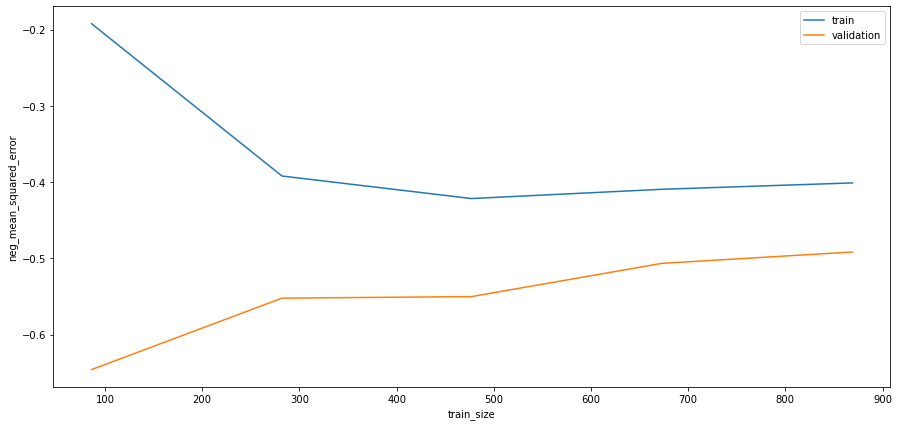

In [52]:
# Calcul des Learning Curve
from sklearn.model_selection import learning_curve
N_lc_lr, train_score_lc_lr, val_score_lc_lr = learning_curve(best_estimator_lr, features_train, target_train, 
                                                             cv = cv, scoring = scoring)
# Tracé des learning Curve
plt.figure(figsize=(15,7))
plt.plot(N_lc_lr, train_score_lc_lr.mean(axis = 1), label = 'train')
plt.plot(N_lc_lr, val_score_lc_lr.mean(axis = 1), label = 'validation')
#plt.ylim(-1,0)
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

### Régularisation Ridge

In [53]:
# Création du modèle de regression lineaire Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

ridge_model = make_pipeline(preprocessor, Ridge())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_rg = cross_val_score(ridge_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_rg.mean()

-0.4717810043292606

In [54]:
# Recherche des meilleurs hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV

n_alphas = 5
alphas = np.logspace(-1, 3, n_alphas)
params = {'ridge__alpha' : alphas}

grid_ridge = GridSearchCV(ridge_model, param_grid = params, 
                          return_train_score = True,
                          scoring = scoring, cv =cv)
grid_ridge.fit(features_train, target_train)
best_score_rg = grid_ridge.best_score_
best_param_rg = grid_ridge.best_params_
best_estimator_rg = grid_ridge.best_estimator_
grid_results_rg = pd.DataFrame(grid_ridge.cv_results_)
display(best_score_rg, best_param_rg, grid_results_rg)

-0.4717810043292606

{'ridge__alpha': 1.0}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.032979,0.010788,0.009594,0.005311,0.1,{'ridge__alpha': 0.1},-0.513664,-0.596994,-0.364300,-0.544706,-0.402409,-0.484415,0.087541,3,-0.392770,-0.373398,-0.433357,-0.392927,-0.423859,-0.403262,0.022085
1,0.030968,0.011128,0.009926,0.003160,1,{'ridge__alpha': 1.0},-0.518286,-0.583288,-0.362781,-0.499277,-0.395272,-0.471781,0.081348,1,-0.400737,-0.382442,-0.439299,-0.404022,-0.431202,-0.411540,0.020866
2,0.024686,0.003136,0.008412,0.001744,10,{'ridge__alpha': 10.0},-0.560815,-0.582777,-0.390517,-0.465320,-0.410388,-0.481964,0.077645,2,-0.433361,-0.423453,-0.473477,-0.448600,-0.468225,-0.449423,0.019314
3,0.024069,0.007915,0.005996,0.005056,100,{'ridge__alpha': 100.0},-0.652033,-0.658843,-0.489684,-0.490530,-0.498911,-0.558000,0.079652,4,-0.521910,-0.521852,-0.562641,-0.556055,-0.564266,-0.545345,0.019354
4,0.028110,0.006585,0.004795,0.003966,1000,{'ridge__alpha': 1000.0},-0.868746,-0.932839,-0.782377,-0.700652,-0.818800,-0.820683,0.078444,5,-0.789314,-0.805646,-0.813443,-0.838781,-0.831554,-0.815747,0.017813


In [55]:
# Visualisation des coefficients du meilleur estimateur
best_rg_model = best_estimator_rg.named_steps['ridge']
display(best_lr_model.coef_, best_rg_model.coef_)

array([ 0.43021263, -1.1992541 ,  1.98042151, -0.71340462, -0.16837474,
       -0.41417842,  0.60392674,  0.58012765, -0.09962273,  0.01521131,
       -0.08093688,  0.18757366, -0.40547429, -0.47515697,  0.14085036,
       -0.11513759, -1.06209923, -0.03557961, -0.75712768,  0.00921719,
        2.0642255 ,  0.35277477, -0.34021904, -0.2803191 , -0.44751929,
       -0.14835446, -0.16837474, -0.19544084,  0.43307623,  2.28585566,
       -0.41417842, -0.31734435,  0.26466021, -1.61883109,  0.60392674,
       -0.38573352, -0.09962273,  1.17369386, -0.54040497,  0.13772424,
        0.38639162,  0.31469765, -0.27822195,  0.26912219, -0.42998671,
       -0.10872103, -0.00373347, -1.12524273,  0.04795924, -0.10286032,
        0.82116391, -0.22898352,  0.21190237,  1.35978325, -0.65756236,
       -0.23806955,  0.66360311,  0.11449012, -0.96314671, -0.7811079 ,
       -0.21950152, -0.11513759, -0.56716107,  0.74789501, -0.52156845,
        1.99655741,  0.02121435, -0.75712768,  0.02295017,  0.16

array([ 3.68470892e-01,  2.11232814e-01,  6.69930161e-01, -2.10278438e-01,
       -1.82377622e-01, -4.09385206e-01,  5.01429377e-01,  2.29274046e-01,
       -1.05945087e-01,  2.00707306e-02,  1.00735378e-01,  1.51987140e-01,
       -4.37680056e-01, -2.79976122e-01,  1.31350517e-01, -1.20451139e-01,
        6.04232622e-02, -4.00835652e-02, -7.56080407e-01,  3.15401953e-02,
        1.21653915e+00,  2.29870809e-01, -3.41241401e-01, -1.93194096e-01,
       -3.75717148e-01, -9.63159537e-02, -1.82377622e-01, -1.00594079e-01,
        1.73267158e-01,  1.77721669e+00, -4.09385206e-01, -2.12023607e-01,
        2.18707932e-01, -7.46951307e-01,  5.01429377e-01, -6.50186928e-02,
       -1.05945087e-01,  9.75631750e-01, -4.30375993e-01,  1.21308700e-01,
        1.76047343e-01,  1.35144042e-01, -2.59190732e-01,  2.37267068e-01,
       -3.98845084e-01, -1.35005015e-01, -3.55483817e-03, -7.99577203e-01,
        4.20656657e-02, -8.88216801e-02,  6.41179220e-01, -1.01175416e-01,
        2.32580701e-01,  

In [56]:
# Calcul residu
best_estimator_rg.fit(features_train, target_train)
rg_target_trans_predict = best_estimator_rg.predict(features_train)
rg_residuals = target_train - rg_target_trans_predict

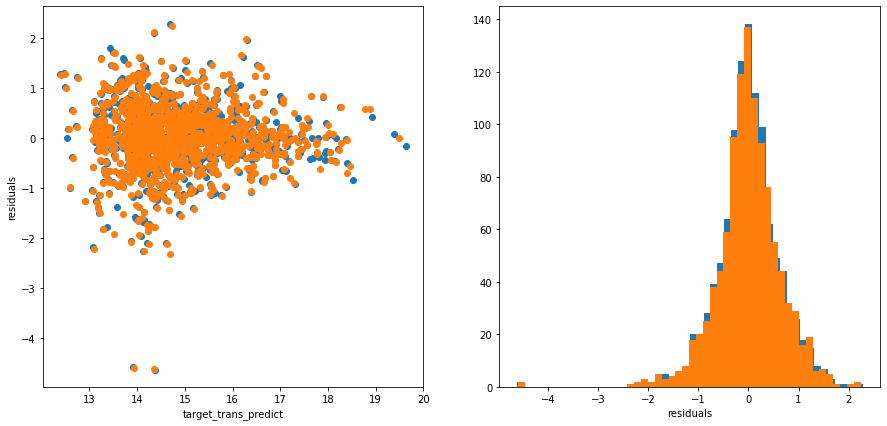

In [57]:
#Tracé des résidus et leurs distributions
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(lr_target_trans_predict, lr_residuals, label = 'linear regression')
plt.scatter(rg_target_trans_predict, rg_residuals, label = 'Ridge regression')
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(lr_residuals, bins = 50)
plt.hist(rg_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [58]:
# Learning Curve
from sklearn.model_selection import learning_curve

N_lc_rg, train_score_lc_rg, val_score_lc_rg = learning_curve(best_estimator_rg, features_train, target_train,
                                                             cv = cv, scoring = scoring)

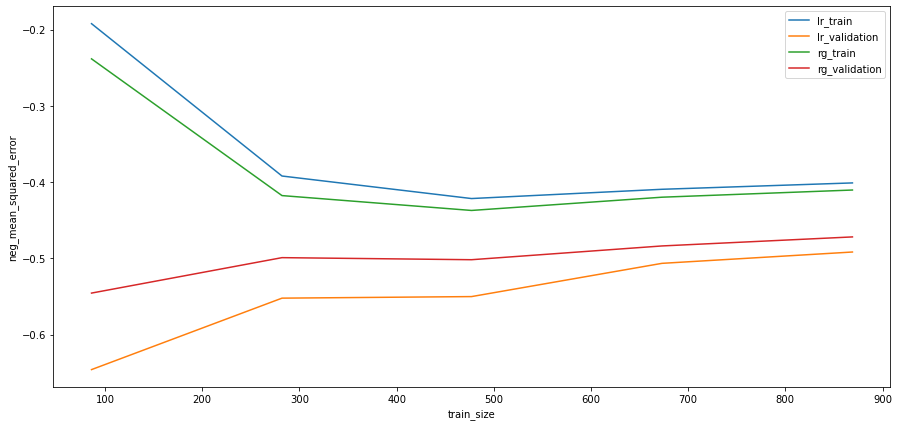

In [59]:
# Tracé des learning Curve
plt.figure(figsize=(15,7))
plt.plot(N_lc_lr, train_score_lc_lr.mean(axis = 1), label = 'lr_train')
plt.plot(N_lc_lr, val_score_lc_lr.mean(axis = 1), label = 'lr_validation')
plt.plot(N_lc_rg, train_score_lc_rg.mean(axis = 1), label = 'rg_train')
plt.plot(N_lc_rg, val_score_lc_rg.mean(axis = 1), label = 'rg_validation')
#plt.ylim(-1,0)
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

### Régularisation Lasso

In [60]:
# Création du modèle de regression lineaire Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

lasso_model = make_pipeline(preprocessor, Lasso())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_la = cross_val_score(lasso_model, features_train, target_train, scoring = scoring, cv =cv)
val_score_la.mean()

-1.6951156003501981

In [61]:
# Recherche des meilleurs hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV

n_alphas = 5
alphas = np.logspace(-1, 3, n_alphas)
params = {'lasso__alpha' : alphas}

grid_lasso = GridSearchCV(lasso_model, param_grid = params, 
                          return_train_score = True,
                          scoring = scoring, cv =cv)
grid_lasso.fit(features_train, target_train)
best_score_la = grid_lasso.best_score_
best_param_la = grid_lasso.best_params_
best_estimator_la = grid_lasso.best_estimator_
grid_results_la = pd.DataFrame(grid_lasso.cv_results_)
display(best_score_la, best_param_la, grid_results_la)

-0.7044676017445615

{'lasso__alpha': 0.1}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.031033,0.005311,0.010181,0.004029,0.1,{'lasso__alpha': 0.1},-0.799702,-0.785518,-0.657393,-0.621534,-0.658191,-0.704468,0.073313,1,-0.671457,-0.685365,-0.714158,-0.717690,-0.717685,-0.701271,0.019219
1,0.025322,0.003302,0.007638,0.001027,1,{'lasso__alpha': 1.0},-1.661645,-1.726536,-1.810653,-1.504620,-1.772125,-1.695116,0.107402,2,-1.701129,-1.684710,-1.663738,-1.740855,-1.673324,-1.692751,0.027085
2,0.022248,0.007698,0.002009,0.002760,10,{'lasso__alpha': 10.0},-1.661645,-1.726536,-1.810653,-1.504620,-1.772125,-1.695116,0.107402,2,-1.701129,-1.684710,-1.663738,-1.740855,-1.673324,-1.692751,0.027085
3,0.023317,0.006423,0.007718,0.005035,100,{'lasso__alpha': 100.0},-1.661645,-1.726536,-1.810653,-1.504620,-1.772125,-1.695116,0.107402,2,-1.701129,-1.684710,-1.663738,-1.740855,-1.673324,-1.692751,0.027085
4,0.019088,0.006115,0.003125,0.006250,1000,{'lasso__alpha': 1000.0},-1.661645,-1.726536,-1.810653,-1.504620,-1.772125,-1.695116,0.107402,2,-1.701129,-1.684710,-1.663738,-1.740855,-1.673324,-1.692751,0.027085


In [62]:
# Visualisation des coefficient du meilleurs estimateurs
best_la_model = best_estimator_la.named_steps['lasso']
display(best_lr_model.coef_, best_rg_model.coef_, best_la_model.coef_)

array([ 0.43021263, -1.1992541 ,  1.98042151, -0.71340462, -0.16837474,
       -0.41417842,  0.60392674,  0.58012765, -0.09962273,  0.01521131,
       -0.08093688,  0.18757366, -0.40547429, -0.47515697,  0.14085036,
       -0.11513759, -1.06209923, -0.03557961, -0.75712768,  0.00921719,
        2.0642255 ,  0.35277477, -0.34021904, -0.2803191 , -0.44751929,
       -0.14835446, -0.16837474, -0.19544084,  0.43307623,  2.28585566,
       -0.41417842, -0.31734435,  0.26466021, -1.61883109,  0.60392674,
       -0.38573352, -0.09962273,  1.17369386, -0.54040497,  0.13772424,
        0.38639162,  0.31469765, -0.27822195,  0.26912219, -0.42998671,
       -0.10872103, -0.00373347, -1.12524273,  0.04795924, -0.10286032,
        0.82116391, -0.22898352,  0.21190237,  1.35978325, -0.65756236,
       -0.23806955,  0.66360311,  0.11449012, -0.96314671, -0.7811079 ,
       -0.21950152, -0.11513759, -0.56716107,  0.74789501, -0.52156845,
        1.99655741,  0.02121435, -0.75712768,  0.02295017,  0.16

array([ 3.68470892e-01,  2.11232814e-01,  6.69930161e-01, -2.10278438e-01,
       -1.82377622e-01, -4.09385206e-01,  5.01429377e-01,  2.29274046e-01,
       -1.05945087e-01,  2.00707306e-02,  1.00735378e-01,  1.51987140e-01,
       -4.37680056e-01, -2.79976122e-01,  1.31350517e-01, -1.20451139e-01,
        6.04232622e-02, -4.00835652e-02, -7.56080407e-01,  3.15401953e-02,
        1.21653915e+00,  2.29870809e-01, -3.41241401e-01, -1.93194096e-01,
       -3.75717148e-01, -9.63159537e-02, -1.82377622e-01, -1.00594079e-01,
        1.73267158e-01,  1.77721669e+00, -4.09385206e-01, -2.12023607e-01,
        2.18707932e-01, -7.46951307e-01,  5.01429377e-01, -6.50186928e-02,
       -1.05945087e-01,  9.75631750e-01, -4.30375993e-01,  1.21308700e-01,
        1.76047343e-01,  1.35144042e-01, -2.59190732e-01,  2.37267068e-01,
       -3.98845084e-01, -1.35005015e-01, -3.55483817e-03, -7.99577203e-01,
        4.20656657e-02, -8.88216801e-02,  6.41179220e-01, -1.01175416e-01,
        2.32580701e-01,  

array([ 0.        ,  1.15696046,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.  

In [63]:
# Calcul des résidus
best_estimator_la.fit(features_train, target_train)
la_target_trans_predict = best_estimator_la.predict(features_train)
la_residuals = target_train - la_target_trans_predict

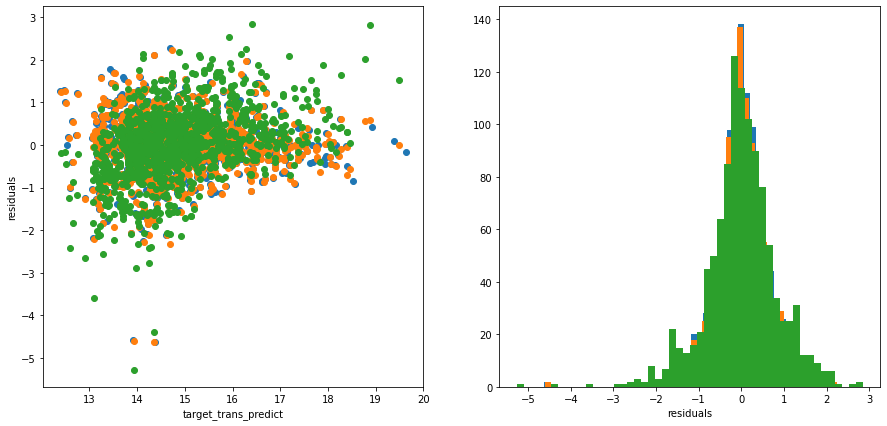

In [64]:
# Tracé des résidus et leurs distributions
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(lr_target_trans_predict, lr_residuals, label = 'linear regression')
plt.scatter(rg_target_trans_predict, rg_residuals, label = 'Ridge regression')
plt.scatter(rg_target_trans_predict, la_residuals, label = 'Lasso regression')
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(lr_residuals, bins = 50)
plt.hist(rg_residuals, bins = 50)
plt.hist(la_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [65]:
# Learning Curve
from sklearn.model_selection import learning_curve
N_lc_la, train_score_lc_la, val_score_lc_la = learning_curve(best_estimator_la, features_train, target_train,
                                                             cv = cv, scoring = scoring)

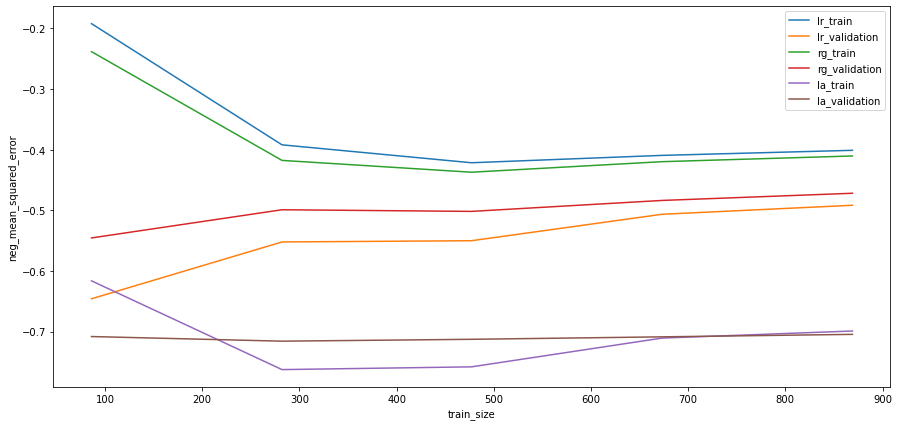

In [66]:
# Tracé des learning Curve et Résidus
plt.figure(figsize=(15,7))
plt.plot(N_lc_lr, train_score_lc_lr.mean(axis = 1), label = 'lr_train')
plt.plot(N_lc_lr, val_score_lc_lr.mean(axis = 1), label = 'lr_validation')
plt.plot(N_lc_rg, train_score_lc_rg.mean(axis = 1), label = 'rg_train')
plt.plot(N_lc_rg, val_score_lc_rg.mean(axis = 1), label = 'rg_validation')
plt.plot(N_lc_la, train_score_lc_la.mean(axis = 1), label = 'la_train')
plt.plot(N_lc_la, val_score_lc_la.mean(axis = 1), label = 'la_validation')
#plt.ylim(-1,0)
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.legend()
plt.show()

## Decision Tree

In [67]:
# Création du modèle d'arbre de décision
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

tree_model = make_pipeline(preprocessor, DecisionTreeRegressor())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_tr = cross_val_score(tree_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_tr.mean()

-0.8658968214690818

In [68]:
# Recherche du meilleur k sur Grille -scoring MSE
from sklearn.model_selection import GridSearchCV

params = {#'decisiontreeregressor__max_depth' : [50, 100, 200, 500],
          'decisiontreeregressor__max_features' : ['auto', 'sqrt'],
          'decisiontreeregressor__min_samples_split' : [0.1, 0.3, 0.5, 0.7, 0.9],
          'decisiontreeregressor__max_leaf_nodes' : [10, 20, 50, 80, 100, 150, 200],
          'decisiontreeregressor__splitter' : ['best', 'random'],
          }

grid_tr = GridSearchCV(tree_model, param_grid = params, scoring = scoring, 
                       return_train_score = True, 
                       cv = cv)
grid_tr.fit(features_train, target_train)
best_score_tr = grid_tr.best_score_
best_param_tr = grid_tr.best_params_
best_estimator_tr = grid_tr.best_estimator_
grid_results_tr = pd.DataFrame(grid_tr.cv_results_)
display(best_score_tr, best_param_tr, grid_results_tr)

-0.573586724332315

{'decisiontreeregressor__max_features': 'auto',
 'decisiontreeregressor__max_leaf_nodes': 150,
 'decisiontreeregressor__min_samples_split': 0.1,
 'decisiontreeregressor__splitter': 'random'}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeregressor__max_features,param_decisiontreeregressor__max_leaf_nodes,param_decisiontreeregressor__min_samples_split,param_decisiontreeregressor__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018964,4.511807e-03,0.005092,0.005857,auto,10,0.1,best,{'decisiontreeregressor__max_features': 'auto'...,-0.796897,-0.764147,-0.622731,-0.613251,-0.609257,-0.681257,0.081826,17,-0.557732,-0.557996,-0.593326,-0.602897,-0.605726,-0.583535,0.021360
1,0.018753,6.247575e-03,0.006250,0.007655,auto,10,0.1,random,{'decisiontreeregressor__max_features': 'auto'...,-0.805355,-0.722382,-0.639720,-0.609554,-0.645600,-0.684522,0.070960,20,-0.593535,-0.603357,-0.689408,-0.644152,-0.643691,-0.634829,0.034176
2,0.018748,6.249762e-03,0.006250,0.007654,auto,10,0.3,best,{'decisiontreeregressor__max_features': 'auto'...,-0.832686,-0.802569,-0.760002,-0.699513,-0.818503,-0.782655,0.048188,37,-0.662484,-0.702224,-0.673235,-0.720334,-0.790356,-0.709727,0.045240
3,0.018748,6.250048e-03,0.006250,0.007655,auto,10,0.3,random,{'decisiontreeregressor__max_features': 'auto'...,-0.840510,-0.898577,-0.844757,-0.749831,-0.606489,-0.788033,0.102576,42,-0.720442,-0.706800,-0.842302,-0.836974,-0.744754,-0.770254,0.057966
4,0.015619,9.622900e-06,0.006250,0.007654,auto,10,0.5,best,{'decisiontreeregressor__max_features': 'auto'...,-0.961687,-0.830193,-0.838309,-0.728991,-0.863748,-0.844586,0.074416,53,-0.753258,-0.735738,-0.802937,-0.758059,-0.820641,-0.774126,0.032128
5,0.019022,6.135765e-03,0.003352,0.006151,auto,10,0.5,random,{'decisiontreeregressor__max_features': 'auto'...,-1.050587,-1.039197,-0.726201,-0.847857,-0.801104,-0.892989,0.130009,75,-0.817985,-0.930905,-0.765198,-0.912813,-0.856006,-0.856581,0.060872
6,0.020031,6.142109e-03,0.007056,0.007149,auto,10,0.7,best,{'decisiontreeregressor__max_features': 'auto'...,-0.961687,-0.880095,-0.838309,-0.796904,-0.890911,-0.873581,0.055189,65,-0.753258,-0.778693,-0.802937,-0.805513,-0.855159,-0.799112,0.033812
7,0.018748,6.249213e-03,0.006245,0.007648,auto,10,0.7,random,{'decisiontreeregressor__max_features': 'auto'...,-1.039527,-1.199313,-1.082889,-0.831240,-0.890480,-1.008690,0.132858,101,-0.916698,-1.007838,-1.157690,-0.937825,-0.942053,-0.992421,0.088094
8,0.015624,2.780415e-07,0.006250,0.007654,auto,10,0.9,best,{'decisiontreeregressor__max_features': 'auto'...,-1.051759,-1.071979,-0.991914,-0.879626,-1.010458,-1.001147,0.067109,92,-0.942446,-0.937891,-0.959359,-0.985294,-0.975760,-0.960150,0.018360
9,0.018749,6.249571e-03,0.003125,0.006250,auto,10,0.9,random,{'decisiontreeregressor__max_features': 'auto'...,-0.978534,-1.191395,-1.074837,-1.095469,-0.959375,-1.059922,0.084267,109,-0.889979,-0.983184,-1.088263,-1.204701,-0.982070,-1.029639,0.107712


In [69]:
# Entrâinement et calcul des résidus

tree_target_trans_predict = best_estimator_tr.predict(features_train)
tree_residuals = target_train - tree_target_trans_predict

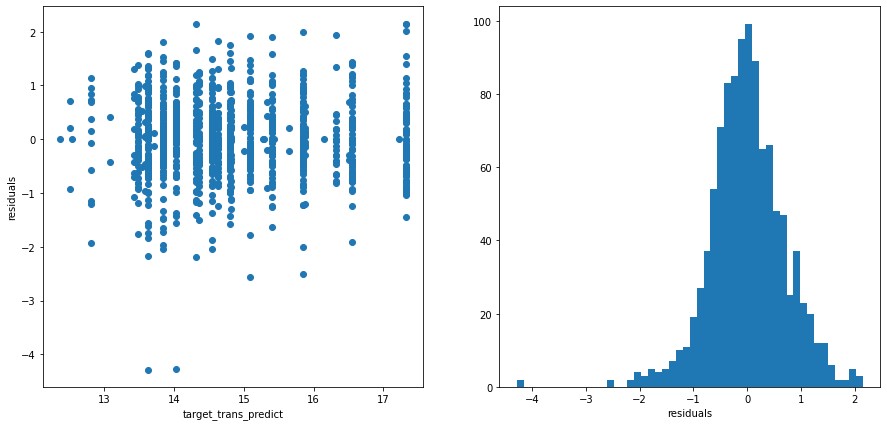

In [70]:
# Tracé des résidus et leurs distributions
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(tree_target_trans_predict, tree_residuals)
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(tree_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [71]:
# Learning Curve
from sklearn.model_selection import learning_curve

N_lc_tr, train_score_lc_tr, val_score_lc_tr = learning_curve(best_estimator_tr, features_train, target_train, 
                                                             train_sizes = np.linspace(0.1,1,10),
                                                             cv = cv, scoring = scoring)

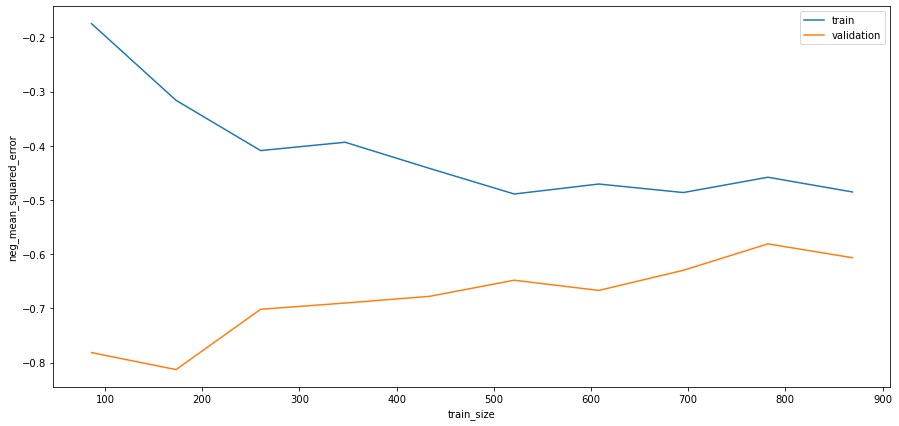

In [72]:
# Tracé des learning Curve
plt.figure(figsize = (15, 7))
plt.plot(N_lc_tr, train_score_lc_tr.mean(axis = 1), label = 'train')
plt.plot(N_lc_tr, val_score_lc_tr.mean(axis = 1), label = 'validation')
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

## RandomForest

In [73]:
# Création du modèle de forêt aléatoire
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

rf_model = make_pipeline(preprocessor, RandomForestRegressor(n_estimators = 100))

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_rf = cross_val_score(rf_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_rf.mean()

-0.5251465007271217

In [74]:
# Recherche du meilleur hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV

params = {#'randomforestregressor__max_depth' : [100, 500, 1000, 2000, 5000],
          'randomforestregressor__max_features' : ['auto', 'sqrt'],
          'randomforestregressor__max_samples' : [0.1, 0.3, 0.5, 0.7, 0.9],
          'randomforestregressor__bootstrap' : [True, False],
          #'randomforestregressor__max_leaf_nodes' : [50, 100, 200, 500, 1000, 2000],
          #'randomforestregressor__min_samples_split' : [0.1, 0.3, 0.5, 0.7, 0.9],
          }

grid_rf = GridSearchCV(rf_model, param_grid = params, scoring = scoring, return_train_score = True, cv = cv)
grid_rf.fit(features_train, target_train)
best_score_rf = grid_rf.best_score_
best_param_rf = grid_rf.best_params_
best_estimator_rf = grid_rf.best_estimator_
grid_results_rf = pd.DataFrame(grid_rf.cv_results_)
display(best_score_rf, best_param_rf, grid_results_rf)

-0.4939806833665467

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_samples': 0.5}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__bootstrap,param_randomforestregressor__max_features,param_randomforestregressor__max_samples,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.288482,0.019434,0.017980,0.003275,True,auto,0.1,"{'randomforestregressor__bootstrap': True, 'ra...",-0.678629,-0.642803,-0.465319,-0.526111,-0.474552,-0.557483,0.087535,10,-0.442430,-4.405065e-01,-0.476395,-4.692782e-01,-0.474562,-0.460634,0.015834
1,0.595556,0.035872,0.023175,0.005554,True,auto,0.3,"{'randomforestregressor__bootstrap': True, 'ra...",-0.628149,-0.613802,-0.437877,-0.536901,-0.454598,-0.534265,0.078466,7,-0.285589,-2.777444e-01,-0.308537,-2.922362e-01,-0.310945,-0.295010,0.012895
2,0.923879,0.185018,0.032569,0.020995,True,auto,0.5,"{'randomforestregressor__bootstrap': True, 'ra...",-0.617440,-0.593544,-0.435881,-0.507586,-0.421769,-0.515244,0.079586,4,-0.196944,-1.902005e-01,-0.204935,-1.876409e-01,-0.211368,-0.198218,0.008897
3,1.607896,0.487996,0.043080,0.015553,True,auto,0.7,"{'randomforestregressor__bootstrap': True, 'ra...",-0.635076,-0.594585,-0.443492,-0.524347,-0.409371,-0.521374,0.085915,6,-0.134027,-1.307723e-01,-0.142831,-1.303464e-01,-0.146606,-0.136916,0.006605
4,1.395663,0.312163,0.020636,0.007258,True,auto,0.9,"{'randomforestregressor__bootstrap': True, 'ra...",-0.636973,-0.609958,-0.465903,-0.541299,-0.417629,-0.534352,0.083193,8,-0.089873,-8.707614e-02,-0.098501,-8.750662e-02,-0.100421,-0.092676,0.005654
5,0.280611,0.046160,0.025330,0.007568,True,sqrt,0.1,"{'randomforestregressor__bootstrap': True, 'ra...",-0.638976,-0.624394,-0.472048,-0.493926,-0.475508,-0.540970,0.074583,9,-0.437287,-4.235292e-01,-0.470536,-4.614386e-01,-0.463690,-0.451296,0.017854
6,0.289828,0.016101,0.016906,0.002551,True,sqrt,0.3,"{'randomforestregressor__bootstrap': True, 'ra...",-0.609915,-0.593271,-0.416710,-0.477461,-0.422214,-0.503914,0.082704,2,-0.270951,-2.644879e-01,-0.285998,-2.782742e-01,-0.294093,-0.278761,0.010511
7,0.376287,0.020739,0.018366,0.003370,True,sqrt,0.5,"{'randomforestregressor__bootstrap': True, 'ra...",-0.592545,-0.590093,-0.397014,-0.478316,-0.411935,-0.493981,0.084062,1,-0.184681,-1.837218e-01,-0.200550,-1.896434e-01,-0.201252,-0.191970,0.007568
8,0.415630,0.007935,0.016104,0.000943,True,sqrt,0.7,"{'randomforestregressor__bootstrap': True, 'ra...",-0.611245,-0.597823,-0.426920,-0.500654,-0.398593,-0.507047,0.086396,3,-0.123856,-1.268385e-01,-0.135330,-1.271684e-01,-0.139220,-0.130483,0.005797
9,0.467695,0.002136,0.021877,0.007653,True,sqrt,0.9,"{'randomforestregressor__bootstrap': True, 'ra...",-0.628601,-0.604694,-0.432162,-0.507451,-0.407714,-0.516124,0.088739,5,-0.090204,-8.480964e-02,-0.094734,-8.923328e-02,-0.097314,-0.091259,0.004372


In [75]:
# Entrâinement et calcul des résidus
rf_target_trans_predict = best_estimator_rf.predict(features_train)
rf_residuals = target_train - rf_target_trans_predict

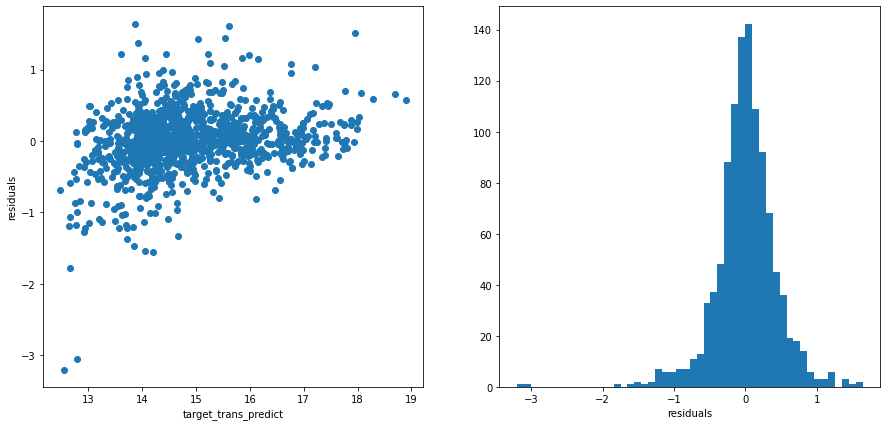

In [76]:
# Tracé des résidus et leurs distributions
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(rf_target_trans_predict, rf_residuals)
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(rf_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [77]:
# Learning Curve
from sklearn.model_selection import learning_curve

N_lc_rf, train_score_lc_rf, val_score_lc_rf = learning_curve(best_estimator_rf, features_train, target_train, 
                                                             train_sizes = np.linspace(0.1,1,10),
                                                             cv = cv, scoring = scoring)

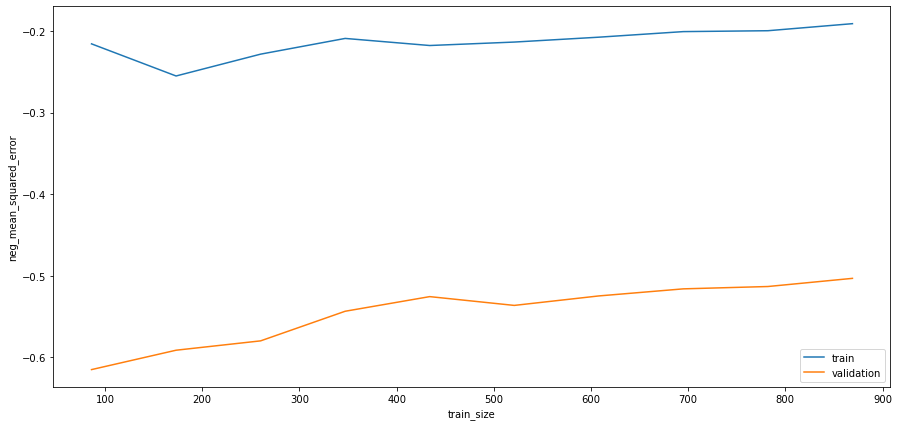

In [78]:
# Tracé des learning Curve
plt.figure(figsize = (15, 7))
plt.plot(N_lc_rf, train_score_lc_rf.mean(axis = 1), label = 'train')
plt.plot(N_lc_rf, val_score_lc_rf.mean(axis = 1), label = 'validation')
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

## Support Vector Machine

In [79]:
# Création du modèle de SVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

svr_model = make_pipeline(preprocessor, SVR())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_svr = cross_val_score(svr_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_svr.mean()

-0.48593675331972125

In [80]:
# Recherche des meilleurs hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV

params = {'svr__gamma' : [0.01, 0.1, 1, 10, 100],
          'svr__C' : [0.01, 0.1, 1, 10, 100, 500],  
         }

grid_svr = GridSearchCV(svr_model, param_grid = params, scoring = scoring, 
                        return_train_score = True,
                        cv = cv)

grid_svr.fit(features_train, target_train)
best_score_svr = grid_svr.best_score_
best_param_svr = grid_svr.best_params_
best_estimator_svr = grid_svr.best_estimator_
grid_results_svr = pd.DataFrame(grid_svr.cv_results_)
display(best_score_svr, best_param_svr, grid_results_svr)

-0.4707802378457693

{'svr__C': 100, 'svr__gamma': 0.01}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.053121,0.007655,0.012497,0.006249,0.01,0.01,"{'svr__C': 0.01, 'svr__gamma': 0.01}",-1.424703,-1.510681,-1.495566,-1.228859,-1.480890,-1.428140,0.103794,23,-1.421535,-1.423654,-1.400053,-1.465900,-1.417011,-1.425631,0.021776
1,0.053121,0.007646,0.012501,0.006251,0.01,0.1,"{'svr__C': 0.01, 'svr__gamma': 0.1}",-0.995638,-1.075992,-0.993053,-0.841882,-1.021082,-0.985530,0.077770,15,-0.971179,-0.945133,-0.993050,-1.004877,-0.983794,-0.979606,0.020476
2,0.056243,0.007652,0.012501,0.006250,0.01,1,"{'svr__C': 0.01, 'svr__gamma': 1}",-1.461323,-1.531735,-1.561921,-1.268704,-1.516653,-1.468067,0.104894,24,-1.451626,-1.424355,-1.452029,-1.481165,-1.436993,-1.449234,0.018984
3,0.087535,0.007691,0.006251,0.007656,0.01,10,"{'svr__C': 0.01, 'svr__gamma': 10}",-1.636045,-1.707851,-1.769529,-1.425530,-1.703297,-1.648451,0.119201,27,-1.630524,-1.620081,-1.609018,-1.665942,-1.603351,-1.625783,0.022145
4,0.071905,0.007676,0.015626,0.000016,0.01,100,"{'svr__C': 0.01, 'svr__gamma': 100}",-1.684139,-1.757450,-1.826889,-1.469277,-1.758758,-1.699303,0.123561,28,-1.679831,-1.674795,-1.650188,-1.723326,-1.653118,-1.676252,0.026250
5,0.056242,0.007659,0.009375,0.007655,0.1,0.01,"{'svr__C': 0.1, 'svr__gamma': 0.01}",-0.769108,-0.797940,-0.647765,-0.599165,-0.677092,-0.698214,0.074530,11,-0.659981,-0.672486,-0.700543,-0.714333,-0.712368,-0.691942,0.021875
6,0.056266,0.012510,0.015626,0.009882,0.1,0.1,"{'svr__C': 0.1, 'svr__gamma': 0.1}",-0.654922,-0.670106,-0.518568,-0.485387,-0.527392,-0.571275,0.075954,7,-0.526647,-0.528706,-0.569025,-0.564999,-0.566617,-0.551199,0.019259
7,0.062517,0.017093,0.015626,0.000002,0.1,1,"{'svr__C': 0.1, 'svr__gamma': 1}",-0.947295,-1.048003,-0.935336,-0.815566,-0.919800,-0.933200,0.074027,14,-0.851521,-0.812442,-0.871539,-0.867155,-0.849818,-0.850495,0.020832
8,0.084368,0.007647,0.015628,0.000001,0.1,10,"{'svr__C': 0.1, 'svr__gamma': 10}",-1.311787,-1.400513,-1.387762,-1.158447,-1.339123,-1.319526,0.086724,20,-1.176971,-1.141571,-1.195243,-1.183617,-1.168694,-1.173219,0.018052
9,0.068745,0.007646,0.018751,0.006249,0.1,100,"{'svr__C': 0.1, 'svr__gamma': 100}",-1.585763,-1.648449,-1.707716,-1.352231,-1.630426,-1.584917,0.122744,26,-1.402979,-1.389603,-1.401027,-1.448872,-1.387326,-1.405961,0.022313


In [81]:
# Entrâinement et calcul des résidus
svr_target_trans_predict = best_estimator_svr.predict(features_train)
svr_residuals = target_train - svr_target_trans_predict

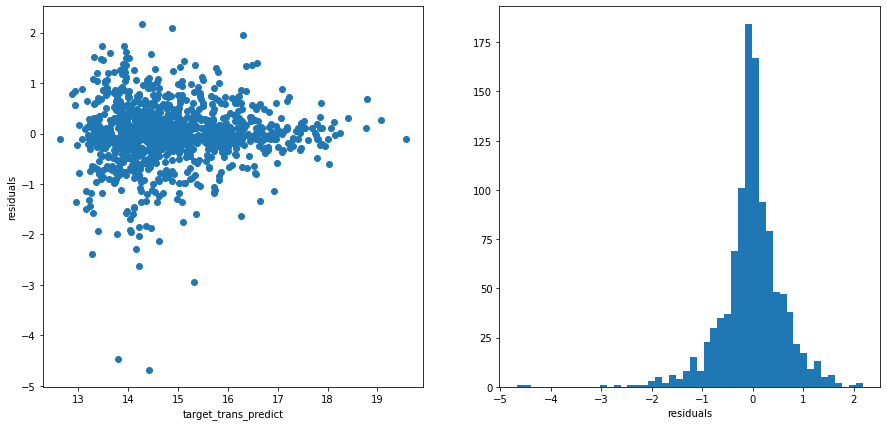

In [82]:
# Tracé des résidus et leurs distributions
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.scatter(svr_target_trans_predict, svr_residuals)
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(svr_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [83]:
# Learning Curve
from sklearn.model_selection import learning_curve

N_lc_svr, train_score_lc_svr, val_score_lc_svr = learning_curve(best_estimator_svr, features_train, target_train,
                                                                train_sizes = np.linspace(0.1,1,10),
                                                                cv = cv, scoring = scoring)

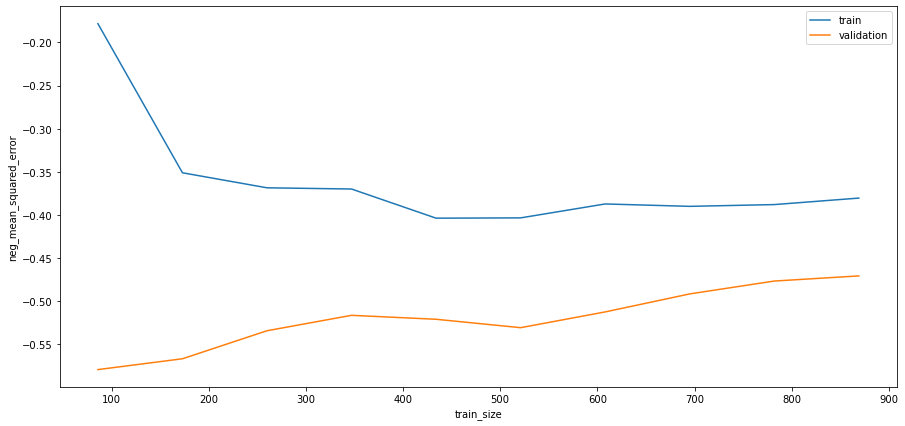

In [84]:
# Tracé des learning Curve
plt.figure(figsize = (15, 7))
plt.plot(N_lc_svr, train_score_lc_svr.mean(axis = 1), label = 'train')
plt.plot(N_lc_svr, val_score_lc_svr.mean(axis = 1), label = 'validation')
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

## Gradient Boosting

In [85]:
# Création du modèle de regression lineaire
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = make_pipeline(preprocessor, GradientBoostingRegressor())

# Cross validation
from sklearn.model_selection import cross_val_score

val_score_gbr = cross_val_score(gbr_model, features_train, target_train, scoring = scoring, cv = cv)
val_score_gbr.mean()

-0.4709725550553848

In [86]:
# Recherche des meilleurs hyperparamètres sur Grille
from sklearn.model_selection import GridSearchCV

params = {'gradientboostingregressor__learning_rate' : [0.01, 0.1, 1],
          'gradientboostingregressor__n_estimators' : [100, 110, 120, 130, 140, 150, 200]
          #'gradientboostingregressor__max_depth' : [1, 2, 3, 5, 7, 10]
         }

grid_gbr = GridSearchCV(gbr_model, param_grid = params, scoring = scoring, cv = cv, 
                        return_train_score = True)
grid_gbr.fit(features_train, target_train)
best_score_gbr = grid_gbr.best_score_
best_param_gbr = grid_gbr.best_params_
best_estimator_gbr = grid_gbr.best_estimator_
grid_results_gbr = pd.DataFrame(grid_gbr.cv_results_)
display(best_score_gbr, best_param_gbr, grid_results_gbr)

-0.46936959239447607

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__n_estimators': 110}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.189706,0.004854,0.009376,0.007655,0.01,100,{'gradientboostingregressor__learning_rate': 0...,-0.813735,-0.872761,-0.747261,-0.670995,-0.758475,-0.772645,0.067660,16,-0.700550,-0.700233,-0.725637,-0.730785,-0.732490,-0.717939,0.014504
1,0.215602,0.017410,0.009241,0.005888,0.01,110,{'gradientboostingregressor__learning_rate': 0...,-0.788685,-0.842664,-0.711872,-0.646655,-0.720820,-0.742139,0.067468,13,-0.665773,-0.665267,-0.692650,-0.695478,-0.699274,-0.683689,0.014984
2,0.264827,0.034819,0.004798,0.003968,0.01,120,{'gradientboostingregressor__learning_rate': 0...,-0.766824,-0.816817,-0.681296,-0.625313,-0.688742,-0.715798,0.067703,12,-0.635703,-0.635190,-0.664225,-0.665143,-0.670725,-0.654197,0.015471
3,0.289261,0.031757,0.008119,0.005159,0.01,130,{'gradientboostingregressor__learning_rate': 0...,-0.748324,-0.794498,-0.655119,-0.608243,-0.663576,-0.693952,0.067590,11,-0.609477,-0.609139,-0.639490,-0.638694,-0.646008,-0.628562,0.015924
4,0.297066,0.040887,0.010649,0.005713,0.01,140,{'gradientboostingregressor__learning_rate': 0...,-0.732772,-0.776000,-0.633553,-0.591930,-0.640416,-0.674934,0.068342,10,-0.586874,-0.585956,-0.618120,-0.614654,-0.623988,-0.605918,0.016204
5,0.278984,0.006872,0.003125,0.006250,0.01,150,{'gradientboostingregressor__learning_rate': 0...,-0.717808,-0.759658,-0.614078,-0.577355,-0.620699,-0.657920,0.068899,9,-0.567133,-0.565884,-0.598909,-0.593351,-0.604197,-0.585895,0.016201
6,0.359377,0.000037,0.006251,0.007656,0.01,200,{'gradientboostingregressor__learning_rate': 0...,-0.677491,-0.700468,-0.544656,-0.532074,-0.548747,-0.600687,0.072664,8,-0.497803,-0.489437,-0.527962,-0.519783,-0.531720,-0.513341,0.016768
7,0.181261,0.007628,0.006250,0.007655,0.1,100,{'gradientboostingregressor__learning_rate': 0...,-0.541497,-0.567569,-0.387198,-0.483498,-0.391961,-0.474345,0.074385,6,-0.310453,-0.286066,-0.324721,-0.309136,-0.326753,-0.311426,0.014567
8,0.196857,0.007652,0.003125,0.006250,0.1,110,{'gradientboostingregressor__learning_rate': 0...,-0.539082,-0.563576,-0.379696,-0.480072,-0.384422,-0.469370,0.076298,1,-0.302067,-0.277842,-0.317190,-0.302843,-0.319211,-0.303831,0.014796
9,0.220688,0.027953,0.009375,0.007654,0.1,120,{'gradientboostingregressor__learning_rate': 0...,-0.540870,-0.572090,-0.384114,-0.483579,-0.383513,-0.472833,0.078033,5,-0.295586,-0.271741,-0.308185,-0.297192,-0.312303,-0.297001,0.014138


In [87]:
# Entrâinement et calcul des résidus
gbr_target_trans_predict = best_estimator_gbr.predict(features_train)
gbr_residuals = target_train - gbr_target_trans_predict

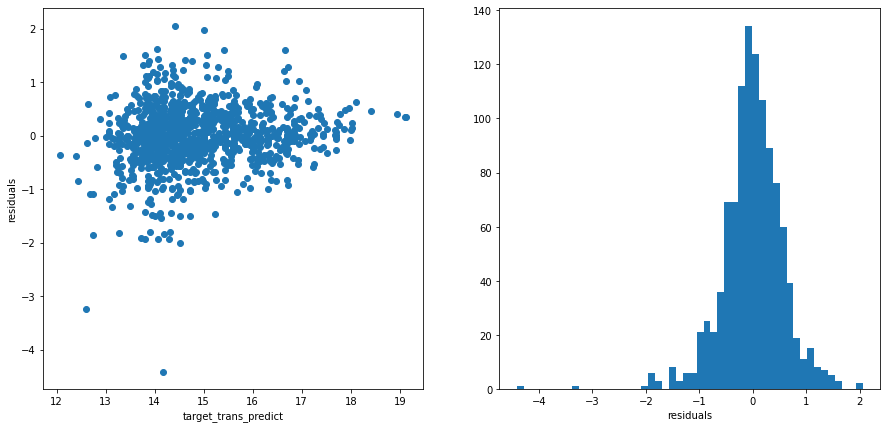

In [88]:
# Tracé des résidus et de distributions
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.scatter(gbr_target_trans_predict, gbr_residuals)
plt.xlabel('target_trans_predict')
plt.ylabel('residuals')
plt.subplot(1, 2, 2)
plt.hist(gbr_residuals, bins = 50)
plt.xlabel('residuals')
plt.show()

In [89]:
# Learning Curve
from sklearn.model_selection import learning_curve

N_lc_gbr, train_score_lc_gbr, val_score_lc_gbr = learning_curve(best_estimator_gbr, features_train, target_train, 
                                                                train_sizes = np.linspace(0.1,1,10),
                                                                cv = cv, scoring = scoring)

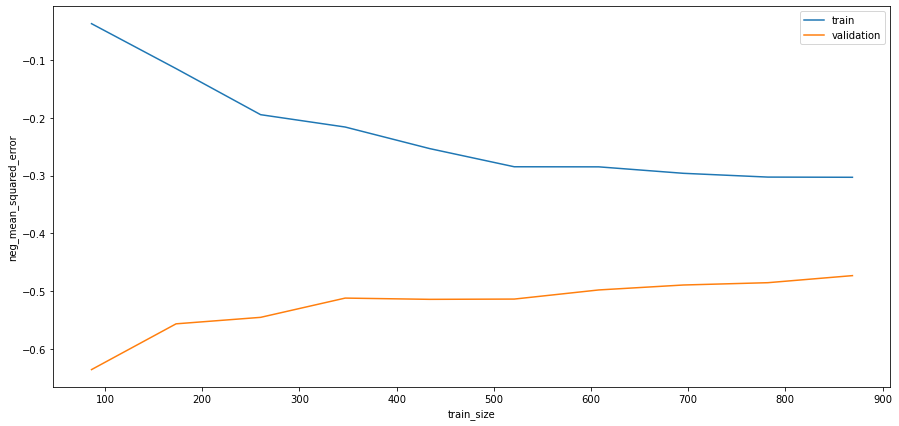

In [90]:
# Tracé des learning Curve
plt.figure(figsize=(15,7))
plt.plot(N_lc_gbr, train_score_lc_gbr.mean(axis = 1), label = 'train')
plt.plot(N_lc_gbr, val_score_lc_gbr.mean(axis = 1), label = 'validation')
plt.legend()
plt.xlabel('train_size')
plt.ylabel(f'{scoring}')
plt.show()

## Enregistrement des resultats de modélisation dans csv 

In [91]:
# Calcul des score en R2
if scoring == 'neg_mean_squared_error':
    r2_score_lr = (1 - (val_score_lr/val_score_0)).mean()
    r2_score_rg = (1 - (val_score_rg/val_score_0)).mean()
    r2_score_la = (1 - (val_score_la/val_score_0)).mean()
    r2_score_tr = (1 - (val_score_tr/val_score_0)).mean()
    r2_score_rf = (1 - (val_score_rf/val_score_0)).mean()
    r2_score_svr = (1 - (val_score_svr/val_score_0)).mean()
    r2_score_gbr = (1 - (val_score_gbr/val_score_0)).mean()
    
    r2_bestscore_lr = (1 - (best_score_lr/val_score_0)).mean()
    r2_bestscore_rg = (1 - (best_score_rg/val_score_0)).mean()
    r2_bestscore_la = (1 - (best_score_la/val_score_0)).mean()
    r2_bestscore_tr = (1 - (best_score_tr/val_score_0)).mean()
    r2_bestscore_rf = (1 - (best_score_rf/val_score_0)).mean()
    r2_bestscore_svr = (1 - (best_score_svr/val_score_0)).mean()
    r2_bestscore_gbr = (1 - (best_score_gbr/val_score_0)).mean()
elif scoring == 'r2':
    r2_score_lr = val_score_lr.mean()
    r2_score_rg = val_score_rg.mean()
    r2_score_la = val_score_la.mean()
    r2_score_tr = val_score_tr.mean()
    r2_score_rf = val_score_rf.mean()
    r2_score_svr = val_score_svr.mean()
    r2_score_gbr = val_score_gbr.mean()
    
    r2_bestscore_lr = best_score_lr.mean()
    r2_bestscore_rg = best_score_rg.mean()
    r2_bestscore_la = best_score_la.mean()
    r2_bestscore_tr = best_score_tr.mean()
    r2_bestscore_rf = best_score_rf.mean()
    r2_bestscore_svr = best_score_svr.mean()
    r2_bestscore_gbr = best_score_gbr.mean()

# Temps de calcul moyen et écart-type :
time_var = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
time_var_lr = grid_results_lr[grid_results_lr['params'] == best_param_lr][time_var]
time_var_rg = grid_results_rg[grid_results_rg['params'] == best_param_rg][time_var]
time_var_la = grid_results_la[grid_results_la['params'] == best_param_la][time_var]
time_var_tr = grid_results_tr[grid_results_tr['params'] == best_param_tr][time_var]
time_var_rf = grid_results_rf[grid_results_rf['params'] == best_param_rf][time_var]
time_var_svr = grid_results_svr[grid_results_svr['params'] == best_param_svr][time_var]
time_var_gbr = grid_results_gbr[grid_results_gbr['params'] == best_param_gbr][time_var]

data_time_var = pd.concat([time_var_lr, time_var_rg, time_var_la, 
                           time_var_tr, time_var_rf, time_var_svr, time_var_gbr], ignore_index = True)

In [92]:
# Creation des dataframes pour enregistrement
data_mod_initscore = pd.DataFrame({'ModelType' : ['LinearRegression', 'LinearRegression', 'Ridge', 'Ridge',
                                                  'Lasso', 'Lasso', 'DecisionTree','DecisionTree',
                                                  'RandomForest', 'RandomForest', 'SVR', 'SVR', 
                                                  'GBR', 'GBR'], 
                                   'ScoreType' : ['MSE', 'R2', 'MSE', 'R2','MSE', 'R2',
                                                  'MSE', 'R2', 'MSE', 'R2',
                                                  'MSE', 'R2','MSE', 'R2'],
                                   'ScoreValue' : [abs(val_score_lr.mean()), r2_score_lr,
                                                   abs(val_score_rg.mean()), r2_score_rg, 
                                                   abs(val_score_la.mean()), r2_score_la,
                                                   abs(val_score_tr.mean()), r2_score_tr,
                                                   abs(val_score_rf.mean()), r2_score_rf,
                                                   abs(val_score_svr.mean()), r2_score_svr,
                                                   abs(val_score_gbr.mean()), r2_score_gbr]
                                  })

data_mod_bestscore = pd.DataFrame({'ModelType' : ['LinearRegression', 'LinearRegression', 'Ridge', 'Ridge',
                                                  'Lasso', 'Lasso', 'DecisionTree','DecisionTree',
                                                  'RandomForest', 'RandomForest', 'SVR', 'SVR', 
                                                  'GBR', 'GBR'], 
                                   'ScoreType' : ['MSE', 'R2', 'MSE', 'R2','MSE', 'R2',
                                                  'MSE', 'R2', 'MSE', 'R2',
                                                  'MSE', 'R2','MSE', 'R2'],
                                   'ScoreValue' : [abs(best_score_lr.mean()), r2_bestscore_lr,
                                                   abs(best_score_rg.mean()), r2_bestscore_rg, 
                                                   abs(best_score_la.mean()), r2_bestscore_la,
                                                   abs(best_score_tr.mean()), r2_bestscore_tr,
                                                   abs(best_score_rf.mean()), r2_bestscore_rf,
                                                   abs(best_score_svr.mean()), r2_bestscore_svr,
                                                   abs(best_score_gbr.mean()), r2_bestscore_gbr]
                                  })

data_mod_bestparam = pd.DataFrame({'LinearRegression' : [best_param_lr], 
                                   'Ridge' : [best_param_rg],
                                   'Lasso' : [best_param_la],
                                   'DecisionTree' : [best_param_tr],
                                   'RandomForest' : [best_param_rf],
                                   'SVR' : [best_param_svr],
                                   'GBR' : [best_param_gbr]
                                  })
data_mod_timescore = data_time_var.rename(index = {0 : 'LinearRegression',
                                                  1 : 'Ridge',
                                                  2 : 'Lasso', 
                                                  3 : 'DecisionTree',
                                                  4 : 'RandomForest',
                                                  5 : 'SVR',
                                                  6 : 'GBR'}).T

In [93]:
if target.isin(target_1).sum() == (target.shape[0]) : 
    t = 'SiteEnergyUse'
elif target.isin(target_2).sum() == (target.shape[0]) : 
    t = 'GHGEmissionsTotal'
    
if preprocessor == preprocessor_1_1:
    p = 'p11'
elif preprocessor == preprocessor_1_2:
    p = 'p12'
elif preprocessor == preprocessor_2_1:
    p = 'p21'
elif preprocessor == preprocessor_2_2:
    p = 'p22'
elif preprocessor == preprocessor_3_1:
    p = 'p31'
elif preprocessor == preprocessor_3_2:
    p = 'p32'
        

# Enregistrement des dataframes en csv
data_mod_initscore.to_csv(f'{t}_{p}_mod_initscore.csv', index = False)
data_mod_bestscore.to_csv(f'{t}_{p}_mod_bestscore.csv', index = False)
data_mod_bestparam.to_csv(f'{t}_{p}_mod_bestparam.csv', index = False)
data_mod_timescore.to_csv(f'{t}_{p}_mod_timescore.csv', index = False)

# Visualisation des scores et temps de calculs

In [107]:
# Chargement des données init
t1_p11_init = pd.read_csv('SiteEnergyUse_p11_mod_initscore.csv')
t1_p12_init = pd.read_csv('SiteEnergyUse_p12_mod_initscore.csv')
t1_p21_init = pd.read_csv('SiteEnergyUse_p21_mod_initscore.csv')
t1_p22_init = pd.read_csv('SiteEnergyUse_p22_mod_initscore.csv')
t1_p31_init = pd.read_csv('SiteEnergyUse_p31_mod_initscore.csv')
t1_p32_init = pd.read_csv('SiteEnergyUse_p32_mod_initscore.csv')
t2_p11_init = pd.read_csv('GHGEmissionsTotal_p11_mod_initscore.csv')
t2_p12_init = pd.read_csv('GHGEmissionsTotal_p12_mod_initscore.csv')
t2_p21_init = pd.read_csv('GHGEmissionsTotal_p21_mod_initscore.csv')
t2_p22_init = pd.read_csv('GHGEmissionsTotal_p22_mod_initscore.csv')
t2_p31_init = pd.read_csv('GHGEmissionsTotal_p31_mod_initscore.csv')
t2_p32_init = pd.read_csv('GHGEmissionsTotal_p32_mod_initscore.csv')

In [108]:
# Chargement des données time
t1_p11_time = pd.read_csv('SiteEnergyUse_p11_mod_timescore.csv')
t1_p12_time = pd.read_csv('SiteEnergyUse_p12_mod_timescore.csv')
t1_p21_time = pd.read_csv('SiteEnergyUse_p21_mod_timescore.csv')
t1_p22_time = pd.read_csv('SiteEnergyUse_p22_mod_timescore.csv')
t1_p31_time = pd.read_csv('SiteEnergyUse_p31_mod_timescore.csv')
t1_p32_time = pd.read_csv('SiteEnergyUse_p32_mod_timescore.csv')
t2_p11_time = pd.read_csv('GHGEmissionsTotal_p11_mod_timescore.csv')
t2_p12_time = pd.read_csv('GHGEmissionsTotal_p12_mod_timescore.csv')
t2_p21_time = pd.read_csv('GHGEmissionsTotal_p21_mod_timescore.csv')
t2_p22_time = pd.read_csv('GHGEmissionsTotal_p22_mod_timescore.csv')
t2_p31_time = pd.read_csv('GHGEmissionsTotal_p31_mod_timescore.csv')
t2_p32_time = pd.read_csv('GHGEmissionsTotal_p32_mod_timescore.csv')

In [109]:
# Chargement des données bestparam
t1_p11_bparam = pd.read_csv('SiteEnergyUse_p11_mod_bestparam.csv')
t1_p12_bparam = pd.read_csv('SiteEnergyUse_p12_mod_bestparam.csv')
t1_p21_bparam = pd.read_csv('SiteEnergyUse_p21_mod_bestparam.csv')
t1_p22_bparam = pd.read_csv('SiteEnergyUse_p22_mod_bestparam.csv')
t1_p31_bparam = pd.read_csv('SiteEnergyUse_p31_mod_bestparam.csv')
t1_p32_bparam = pd.read_csv('SiteEnergyUse_p32_mod_bestparam.csv')
t2_p11_bparam = pd.read_csv('GHGEmissionsTotal_p11_mod_bestparam.csv')
t2_p12_bparam = pd.read_csv('GHGEmissionsTotal_p12_mod_bestparam.csv')
t2_p21_bparam = pd.read_csv('GHGEmissionsTotal_p21_mod_bestparam.csv')
t2_p22_bparam = pd.read_csv('GHGEmissionsTotal_p22_mod_bestparam.csv')
t2_p31_bparam = pd.read_csv('GHGEmissionsTotal_p31_mod_bestparam.csv')
t2_p32_bparam = pd.read_csv('GHGEmissionsTotal_p32_mod_bestparam.csv')

In [110]:
# Chargement des données bestparam
t1_p11_bscore = pd.read_csv('SiteEnergyUse_p11_mod_bestscore.csv')
t1_p12_bscore = pd.read_csv('SiteEnergyUse_p12_mod_bestscore.csv')
t1_p21_bscore = pd.read_csv('SiteEnergyUse_p21_mod_bestscore.csv')
t1_p22_bscore = pd.read_csv('SiteEnergyUse_p22_mod_bestscore.csv')
t1_p31_bscore = pd.read_csv('SiteEnergyUse_p31_mod_bestscore.csv')
t1_p32_bscore = pd.read_csv('SiteEnergyUse_p32_mod_bestscore.csv')
t2_p11_bscore = pd.read_csv('GHGEmissionsTotal_p11_mod_bestscore.csv')
t2_p12_bscore = pd.read_csv('GHGEmissionsTotal_p12_mod_bestscore.csv')
t2_p21_bscore = pd.read_csv('GHGEmissionsTotal_p21_mod_bestscore.csv')
t2_p22_bscore = pd.read_csv('GHGEmissionsTotal_p22_mod_bestscore.csv')
t2_p31_bscore = pd.read_csv('GHGEmissionsTotal_p31_mod_bestscore.csv')
t2_p32_bscore = pd.read_csv('GHGEmissionsTotal_p32_mod_bestscore.csv')

In [111]:
display(t1_p11_bscore, t1_p21_bscore, t1_p31_bscore)

,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.492074
1,LinearRegression,R2,0.708475
2,Ridge,MSE,0.473458
3,Ridge,R2,0.719504
4,Lasso,MSE,0.704699
5,Lasso,R2,0.582507
6,DecisionTree,MSE,0.584949
7,DecisionTree,R2,0.653452
8,RandomForest,MSE,0.521462
9,RandomForest,R2,0.691064


,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.491649
1,LinearRegression,R2,0.708726
2,Ridge,MSE,0.471781
3,Ridge,R2,0.720497
4,Lasso,MSE,0.704468
5,Lasso,R2,0.582644
6,DecisionTree,MSE,0.573587
7,DecisionTree,R2,0.660183
8,RandomForest,MSE,0.493981
9,RandomForest,R2,0.707345


,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,1.249788e+22
1,LinearRegression,R2,-7.404264e+21
2,Ridge,MSE,4.797251e-01
3,Ridge,R2,7.157908e-01
4,Lasso,MSE,5.427883e-01
5,Lasso,R2,6.784296e-01
6,DecisionTree,MSE,5.765786e-01
7,DecisionTree,R2,6.584108e-01
8,RandomForest,MSE,5.013124e-01
9,RandomForest,R2,7.030016e-01


In [112]:
display(t2_p11_bscore, t2_p21_bscore, t2_p31_bscore)

,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.948671
1,LinearRegression,R2,0.516141
2,Ridge,MSE,0.911201
3,Ridge,R2,0.535252
4,Lasso,MSE,1.217787
5,Lasso,R2,0.378882
6,DecisionTree,MSE,1.054183
7,DecisionTree,R2,0.462326
8,RandomForest,MSE,0.930071
9,RandomForest,R2,0.525628


,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.947832
1,LinearRegression,R2,0.516569
2,Ridge,MSE,0.909806
3,Ridge,R2,0.535964
4,Lasso,MSE,1.217787
5,Lasso,R2,0.378882
6,DecisionTree,MSE,1.072787
7,DecisionTree,R2,0.452837
8,RandomForest,MSE,0.934714
9,RandomForest,R2,0.523260


,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,3.622285e+22
1,LinearRegression,R2,-1.847505e+22
2,Ridge,MSE,9.181220e-01
3,Ridge,R2,5.317223e-01
4,Lasso,MSE,1.019608e+00
5,Lasso,R2,4.799607e-01
6,DecisionTree,MSE,1.073999e+00
7,DecisionTree,R2,4.522189e-01
8,RandomForest,MSE,9.382015e-01
9,RandomForest,R2,5.214810e-01


# Evaluation du modèle final

In [113]:
# Choix modèles final SiteEnergyUse
display(t1_p21_bscore, t1_p21_time, t1_p21_bparam)

,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.491649
1,LinearRegression,R2,0.708726
2,Ridge,MSE,0.471781
3,Ridge,R2,0.720497
4,Lasso,MSE,0.704468
5,Lasso,R2,0.582644
6,DecisionTree,MSE,0.573587
7,DecisionTree,R2,0.660183
8,RandomForest,MSE,0.493981
9,RandomForest,R2,0.707345


,LinearRegression,Ridge,Lasso,DecisionTree,RandomForest,SVR,GBR
0,0.042037,0.030968,0.031033,0.027722,0.376287,0.085791,0.196857
1,0.011340,0.011128,0.005311,0.009063,0.020739,0.006983,0.007652
2,0.011251,0.009926,0.010181,0.006397,0.018366,0.009377,0.003125
3,0.003697,0.003160,0.004029,0.005568,0.003370,0.007656,0.006250


,LinearRegression,Ridge,Lasso,DecisionTree,RandomForest,SVR,GBR
0,{},{'ridge__alpha': 1.0},{'lasso__alpha': 0.1},{'decisiontreeregressor__max_features': 'auto'...,"{'randomforestregressor__bootstrap': True, 'ra...","{'svr__C': 100, 'svr__gamma': 0.01}",{'gradientboostingregressor__learning_rate': 0...


In [114]:
# Choix modèles final GHGEmissions
display(t2_p21_bscore, t2_p21_time, t2_p21_bparam)

,ModelType,ScoreType,ScoreValue
0,LinearRegression,MSE,0.947832
1,LinearRegression,R2,0.516569
2,Ridge,MSE,0.909806
3,Ridge,R2,0.535964
4,Lasso,MSE,1.217787
5,Lasso,R2,0.378882
6,DecisionTree,MSE,1.072787
7,DecisionTree,R2,0.452837
8,RandomForest,MSE,0.934714
9,RandomForest,R2,0.523260


,LinearRegression,Ridge,Lasso,DecisionTree,RandomForest,SVR,GBR
0,0.044775,0.026189,0.039806,0.025379,0.319652,0.079161,0.198882
1,0.006237,0.003647,0.006429,0.003652,0.010992,0.004575,0.000899
2,0.007597,0.007595,0.008367,0.008239,0.020386,0.015590,0.007596
3,0.001356,0.000800,0.001343,0.001040,0.000808,0.001493,0.000489


,LinearRegression,Ridge,Lasso,DecisionTree,RandomForest,SVR,GBR
0,{},{'ridge__alpha': 1.0},{'lasso__alpha': 0.1},{'decisiontreeregressor__max_features': 'auto'...,"{'randomforestregressor__bootstrap': True, 'ra...","{'svr__C': 10, 'svr__gamma': 0.01}",{'gradientboostingregressor__learning_rate': 0...


In [115]:
# Construction des modèles finaux
from sklearn.linear_model import Ridge

final_model_t1 = make_pipeline(preprocessor_2_1, Ridge(alpha = 1.0))
final_model_t2 = make_pipeline(preprocessor_2_1, Ridge(alpha = 1.0))

In [101]:
# Division entre training et test set
from sklearn.model_selection import train_test_split
features_1_train, features_1_test, target_1_train, target_1_test = train_test_split(features_2_1, target_1,
                                                                                    test_size=0.2,
                                                                                    random_state = 1)
features_2_train, features_2_test, target_2_train, target_2_test = train_test_split(features_2_1, target_2,
                                                                                    test_size=0.2,
                                                                                    random_state = 1)


In [104]:
# Fit des modèles finaux
final_model_t1.fit(features_1_train, target_1_train)
final_model_t2.fit(features_2_train, target_2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['PropertyGFABuilding(s)',
                                                   'PropertyGFATotal',
                                                   'LargestPropertyUseTypeGFA',
                                                   'LargestPropertyUseTypeGFARatio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                 

In [105]:
# Calcul des predictions des targets 
predict_target_1 = final_model_t1.predict(features_1_test)
predict_target_2 = final_model_t2.predict(features_2_test)

In [106]:
# Calcul des erreurs
from sklearn.metrics import mean_squared_error, r2_score

# Calcul MSE
MSE_t1 = mean_squared_error(target_1_test, predict_target_1)
MSE_t2 = mean_squared_error(target_2_test, predict_target_2)

# Score R2
R2_t1 = r2_score(target_1_test, predict_target_1)
R2_t2 = r2_score(target_2_test, predict_target_2)
display(f"MSE_t1 : {MSE_t1}, R2_t1 : {R2_t1}, MSE_t2 : {MSE_t2}, R2_t2 : {R2_t2}")

'MSE_t1 : 0.6018381074557183, R2_t1 : 0.6721887518831655, MSE_t2 : 0.9649816316303803, R2_t2 : 0.5403759628064618'

In [44]:
# Calcul des SiteEnergyUse et GHGE et Comparaision
site_EU = np.exp(target_1_test) - 1
GHGE = np.exp(target_2_test) - 1
predict_site_EU = np.exp(predict_target_1) - 1
predict_GHGE = np.exp(predict_target_2) - 1

R2_site_EU = r2_score(site_EU, predict_site_EU)
R2_GHGE = r2_score(GHGE, predict_GHGE)

error_1 = site_EU - pd.Series(predict_site_EU, index = site_EU.index)
error_2 = GHGE - pd.Series(predict_GHGE, index = GHGE.index)

C:\Users\ilyas\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ilyas\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


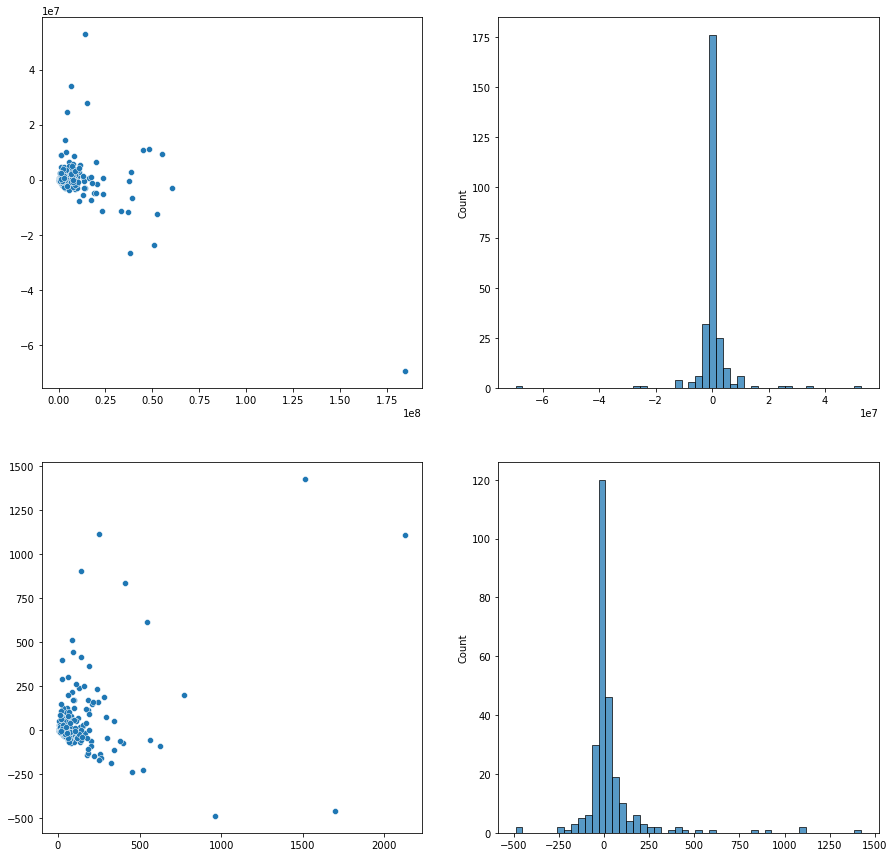

In [45]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.scatterplot(predict_site_EU, error_1)
plt.subplot(2,2,2)
sns.histplot(error_1, bins = 50)
plt.subplot(2,2,3)
sns.scatterplot(predict_GHGE, error_2)
plt.subplot(2,2,4)
sns.histplot(error_2, bins = 50)
plt.show()

